In [1]:
import sys
sys.path.append("../")

In [2]:
import pandas as pd
import plotly.graph_objects as go
from plotting import CandlePlot
import numpy as np

from simulation.pair_trade_percent_binance import PairTradePercent
from technicals.indicators import Donchian_Close

from functools import reduce


from sklearn.preprocessing import StandardScaler

In [3]:

from multiprocessing import Process, Manager
import pickle
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.linear_model import LinearRegression

def synchronize_dataframes(dfs, df_target, target_name='Target'):
    """
    Sincroniza múltiplos DataFrames pelo timestamp e calcula o índice baseado em regressão multivariada.
    :param dfs: Lista de DataFrames contendo os preços de fechamento dos ativos.
    :param df_target: DataFrame do ativo alvo.
    :param target_name: Nome do ativo alvo (usado no resultado final).
    :return: DataFrame sincronizado com o índice de regressão e o spread.
    """
    # Mesclar todos os DataFrames pelo Timestamp
    df = df_target[['Time', 'Close', 'High', 'Low']].rename(columns={'Close': target_name})
    for i, df_pair in enumerate(dfs):
        df = pd.merge(df, df_pair[['Time', 'Close']].rename(columns={'Close': f'Asset_{i}'}), 
                      on='Time', how='inner')
    return df

def apply_regression(df, target_name):
    # # Aplicar regressão para criar o índice base
    # asset_columns = [col for col in df.columns if col.startswith('Asset_')]
    # X = df[asset_columns].values  # Matriz de ativos do cluster
    # y = df[target_name].values  # Preços do ativo alvo
    # model = LinearRegression().fit(X, y)
    # df['Regression_Index'] = model.predict(X)

    """
    Aplica regressão linear com normalização para calcular o índice base.
    """
    asset_columns = [col for col in df.columns if col.startswith('Asset_')]
    X = df[asset_columns].values  # Matriz de ativos do cluster
    y = df[target_name].values  # Preços do ativo alvo

    # Normalizar os dados
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)
    y_normalized = scaler.fit_transform(y.reshape(-1, 1)).flatten()

    # Aplicar regressão
    model = LinearRegression().fit(X_normalized, y_normalized)
    y_pred_normalized = model.predict(X_normalized)

    # Reverter a normalização para obter o índice em escala original
    y_pred = scaler.inverse_transform(y_pred_normalized.reshape(-1, 1)).flatten()
    df['Regression_Index'] = y_pred
    
    return df

def calculate_zscore(df, spread_column='Spread', window=50):
    """
    Calcula o Z-Score do spread usando uma janela móvel.
    :param df: DataFrame com a coluna 'Spread'.
    :param spread_column: Nome da coluna de spread.
    :param window: Tamanho da janela para calcular a média e o desvio padrão.
    :return: DataFrame atualizado com a coluna 'Z-Score'.
    """
    df['Spread_Mean'] = df[spread_column].rolling(window=window).mean()
    df['Spread_Std'] = df[spread_column].rolling(window=window).std()
    df['Z-Score'] = (df[spread_column] - df['Spread_Mean']) / df['Spread_Std']
    return df


In [5]:
def run_pair(granularity,
             lenght=10000,
             strategy=1,
             target_asset='VIDTUSDT',
             cluster_asset=['AVAXUSDT','BNBUSDT','LTCUSDT'],
             entry_threshold=3,
             exit_threshold=0,
             window=50
            ):

    # Carregar os DataFrames de ativos
    df_target = pd.read_pickle(f"crypto/{target_asset}_{granularity}.pkl")
    dfs_cluster = [
        pd.read_pickle(f"crypto/{asset}_{granularity}.pkl") for asset in cluster_asset
    ]
    
    
    # Sincronizar e calcular o índice PCA e o spread
    df = synchronize_dataframes(dfs_cluster, df_target, target_name=target_asset)
    
    df = apply_regression(df, target_asset)
    
    
    # Calcular o spread com o ativo alvo
    df['Spread'] = df[target_asset] - df['Regression_Index']


    # Calcular o Z-Score do spread
    df = calculate_zscore(df, spread_column='Spread', window=200)

    df['Close_Pair1'] = df[target_asset]
    
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    corr = 0
    spread_vol = 0


    df['time'] = df['Time'].copy()
    df['strategy_pair1'] = 0
    # dff['returns'] = dff['Close'].pct_change()
    df['returns_pair1'] = np.log(df['Close_Pair1'] / df['Close_Pair1'].shift(1))
    df['creturns_pair1'] = df['returns_pair1'].cumsum()
    df['Log_Returns_pair1'] = np.log(df['Close_Pair1'] / df['Close_Pair1'].shift(1))
    df['cLog_Returns_pair1'] = df['Log_Returns_pair1'].cumsum()

    # df = df.iloc[lenght:]
    df = df[df['Time'] >= lenght]
    
    df.dropna(inplace=True)
    
    df.reset_index(drop=True, inplace=True)


    

    
    gt = PairTradePercent(
        df,
        strategy,
        entry_threshold,
        exit_threshold,
        corr,
        spread_vol
    )
    
    gt.run_test()
    return gt
    

In [6]:
import pandas as pd

# Carregar os clusters do arquivo
def load_clusters():
    clusters_df = pd.read_csv('best_clusters_overall.csv')
    clusters = {}
    for target_asset in clusters_df['target_asset'].unique():
        clusters[target_asset] = clusters_df[clusters_df['target_asset'] == target_asset]['asset'].tolist()
    return clusters

# Obter os clusters para cada ativo alvo
clusters = load_clusters()


In [7]:
# Verificar os clusters utilizados
for target_asset, cluster_asset in clusters.items():
    print(f"Ativo Alvo: {target_asset}")
    print(f"Cluster: {cluster_asset[:10]}")


Ativo Alvo: DOTUSDT
Cluster: ['MASKUSDT', 'EOSUSDT', 'SANDUSDT']
Ativo Alvo: DOGEUSDT
Cluster: ['CHRUSDT', 'CELOUSDT', 'EOSUSDT']
Ativo Alvo: ADAUSDT
Cluster: ['DASHUSDT', 'PERPUSDT', 'ACHUSDT', 'CHRUSDT', 'TRXUSDT', 'CELOUSDT', 'APTUSDT', 'EOSUSDT', 'XRPUSDT']
Ativo Alvo: XRPUSDT
Cluster: ['PERPUSDT', 'DASHUSDT', 'APTUSDT', 'TRXUSDT', 'ACHUSDT', 'ALGOUSDT', 'ADAUSDT', 'BCHUSDT', 'BANDUSDT', 'EOSUSDT']
Ativo Alvo: TRXUSDT
Cluster: ['CHRUSDT', 'XRPUSDT', 'CELOUSDT', 'EOSUSDT', 'ADAUSDT']
Ativo Alvo: XLMUSDT
Cluster: ['XRPUSDT', 'CHRUSDT', 'ADAUSDT', 'CELOUSDT', 'EOSUSDT']
Ativo Alvo: APTUSDT
Cluster: ['SANDUSDT', 'EOSUSDT', 'LTCUSDT']
Ativo Alvo: VIDTUSDT
Cluster: ['XRPUSDT', 'CHRUSDT', 'ADAUSDT', 'CELOUSDT', 'EOSUSDT']
Ativo Alvo: AVAXUSDT
Cluster: ['SANDUSDT']
Ativo Alvo: LINKUSDT
Cluster: ['APTUSDT']
Ativo Alvo: EOSUSDT
Cluster: ['ALGOUSDT', 'ACHUSDT', 'CELOUSDT', 'CHRUSDT', 'XRPUSDT']
Ativo Alvo: ETCUSDT
Cluster: ['APTUSDT', 'MASKUSDT', 'DOTUSDT', 'ALPHAUSDT', 'DOGEUSDT', 'ALGOUSDT'

In [8]:
# df.columns

In [9]:
def get_list_args():
    args_dic_list = []
    for target_asset, cluster_asset in clusters.items():
        for granularity in ['1m']:
            for lenght in ['2024-01-01 00:00:00']:
                for strategy in [1]:
                    for entry_threshold in [2, 3,4]:
                        for exit_threshold in [1]:
                            for window in [200]:
                                args_dic = {
                                    "granularity": granularity,
                                    "lenght": lenght,
                                    "strategy": strategy,
                                    "target_asset": target_asset,
                                    "cluster_asset": cluster_asset,  # Limitar a 10 ativos
                                    "entry_threshold": entry_threshold,
                                    "exit_threshold": exit_threshold,
                                    "window": window
                                }
                                args_dic_list.append(args_dic)
    return args_dic_list


In [10]:

def run_process(L, arg):
    # print("PROCESS",arg)
    L.append(
        dict(
            arg=arg,
            target_asset=arg['target_asset'],
            cluster_asset=arg['cluster_asset'],
            granularity=arg['granularity'],
            lenght = arg['lenght'],
            strategy = arg['strategy'],
            entry_threshold = arg['entry_threshold'],
            exit_threshold = arg['exit_threshold'],
            window = arg['window'],
            res=run_pair(
                granularity=arg['granularity'],
                lenght = arg['lenght'],
                strategy= arg['strategy'],
                target_asset=arg['target_asset'],
                cluster_asset=arg['cluster_asset'],
                entry_threshold = arg['entry_threshold'],
                exit_threshold = arg['exit_threshold'],
                window = arg['window']
            )
        )
    )


lista = []
def run_ema_macd():
    with Manager() as manager:
        global lista
        L = manager.list()  # Lista compartilhada entre processos
        args_list = get_list_args()
        print(len(args_list))
        limit = 10
        current = 0
    
        while current < len(args_list):
            print(current)
            processes = []
            todo = len(args_list) - current
            if todo < limit:
                limit = todo
    
            for _ in range(limit):
                processes.append(Process(target=run_process, args=(L, args_list[current])))
                current += 1
    
            for p in processes:
                p.start()
    
            for p in processes:
                p.join()

        print("ALL DONE")
        lista = list(L)

        

In [11]:
%%time

run_ema_macd()

69
0
10
20
30
40
50
60
ALL DONE
CPU times: user 108 ms, sys: 1.05 s, total: 1.15 s
Wall time: 39.3 s


In [12]:


# ddf = lista[0]['res'].df.copy()

In [13]:
# with open(f"./result-pair-trading-new-data-strategy-1-CPA-with-sl-0.05-1min-2023-to-end.pkl", "wb") as f:
#     pickle.dump(lista, f)  # Usa o pickle para salvar o arquivo



In [14]:
# listaa = []

# # Carregar os arquivos e expandir seus conteúdos diretamente na lista principal
# for filename in [
#     "./result-binance-acumulative-percentual-strategy-1-2-3-4-5.pkl",
#     "./result-binance-acumulative-percentual-strategy-6-7-8-9.pkl",
#     "./result-binance-acumulative-percentual-strategy-10-11-12.pkl"
# ]:
#     with open(filename, "rb") as f:
#         listaa.extend(pickle.load(f))
        
# with open(f"./result-binance-acumulative-percentual-strategy-1-12.pkl", "wb") as f:
#     pickle.dump(listaa, f)  # Usa o pickle para salvar o arquivo



In [15]:
# cp = CandlePlot(ddf.iloc[-50000:],candles=False)


# trades_up = cp.df_plot[cp.df_plot.SIGNAL_UP_PAIR1 == 1]

# trades_down = cp.df_plot[cp.df_plot.SIGNAL_DOWN_PAIR1 == 1]

# print(len(trades_up),len(trades_down))

In [16]:

# marker_trade_up = '#abebc6'
# marker_trade_down = '#cccddd'


# markers = 'Close_Pair1'


# cp.add_traces(['Close_Pair1'])


# # # SIGNAL UP
# cp.fig.add_trace(go.Scatter(
#     x = trades_up.sTime,
#     y = trades_up[markers],
#     mode = 'markers',
#     marker_symbol = 'triangle-up',
#     marker=dict(color=marker_trade_up, size=12)
# ))

# cp.fig.add_trace(go.Scatter(
#     x = trades_down.sTime,
#     y = trades_down[markers],
#     mode = 'markers',
#     marker_symbol = 'triangle-down',
#     marker=dict(color=marker_trade_down, size=12)
# ))


# cp.show_plot(height=700, width=1100, sec_traces=['PCA_Index'])

In [15]:
res = lista

# with open(f"./result-binance-acumulative-percentual-new-data-strategy-14-1min-2024-split_profit.pkl", "rb") as f:
#     res = pickle.load(f)

In [16]:

dic_res = []
for r in res:

    if r['res'].len_close > 0:
        signal_up = r['res'].df_results.SIGNAL_UP.values[-1]

        res_pos_s = r['res'].df_results[r['res'].df_results['strategy_pair1'] > 0]
        res_neg_s = r['res'].df_results[r['res'].df_results['strategy_pair1'] <= 0]
        sum_neg_s = res_neg_s.strategy_pair1.sum() *-1
        sum_pos_s = res_pos_s.strategy_pair1.sum()
        dic_res.append(
            dict(
                pair1 = r['target_asset'],
                granularity = r['granularity'],
                strat = round(r['res'].df_results.strategy_pair1.sum(),3),
                c = r['res'].df_results['count'].mean(),
                max_o = max(r['res'].df_results.total_opened),
                st = r['res'].strategy,
                entry_threshold = r['entry_threshold'],
                window = r['window'],
                
                corr = r['res'].corr,
                spread_vol = r['res'].spread_vol,
                s_p_strat = sum_pos_s,
                s_n_strat = sum_neg_s,
                Rel_sum = sum_pos_s/(sum_pos_s+ sum_neg_s),
        
                
                l_p_strat = len(res_pos_s),
                l_n_strat = len(res_neg_s),
                Rel_len = len(res_pos_s)/(len(res_pos_s)+ len(res_neg_s)),

                l_c = r['res'].len_close,
                l_o = r['res'].len_open,
                   

                first_p = r['res'].first_price,
                last_p = r['res'].last_price,

                first_t = r['res'].df_results.start_time.values[0],
                last_t = r['res'].df_results.end_time.values[-1],
                
                r = r['res'].df_results,
                # df = r['res'].df
            )
    )
    # print(f"p={p}  e={e}  dw={dw}  dwp={dwp}   strategy={st}   result={result}")


In [17]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [18]:
df_res = pd.DataFrame(dic_res)

In [19]:
df_sorted_desc = df_res.sort_values(by=['pair1','strat'], ascending=False)

In [20]:
df_sorted_desc.columns

Index(['pair1', 'granularity', 'strat', 'c', 'max_o', 'st', 'entry_threshold',
       'window', 'corr', 'spread_vol', 's_p_strat', 's_n_strat', 'Rel_sum',
       'l_p_strat', 'l_n_strat', 'Rel_len', 'l_c', 'l_o', 'first_p', 'last_p',
       'first_t', 'last_t', 'r'],
      dtype='object')

In [21]:
# Exibir todas as linhas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df_sorted_desc.head(150)[['pair1', 'granularity', 'strat', 'c', 'max_o', 'st', 'entry_threshold',
       'window', 'corr', 'spread_vol', 's_p_strat', 's_n_strat', 'Rel_sum',
       'l_p_strat', 'l_n_strat', 'Rel_len', 'l_c', 'l_o']]

pair1 granularity  strat           c  max_o  st  entry_threshold  \
18    XRPUSDT          1m -0.114   92.356250      1   1                4   
19    XRPUSDT          1m -0.482   65.755916      1   1                3   
9     XRPUSDT          1m -2.353   43.948141      1   1                2   
17    XLMUSDT          1m  1.785   28.128666      1   1                2   
12    XLMUSDT          1m  0.431   42.604965      1   1                3   
15    XLMUSDT          1m  0.046   42.941520      1   1                4   
29   VIDTUSDT          1m  4.459   37.404475      1   1                2   
28   VIDTUSDT          1m  1.944   43.457804      1   1                3   
27   VIDTUSDT          1m  0.514   44.586323      1   1                4   
11    TRXUSDT          1m -0.335   66.673139      1   1                4   
14    TRXUSDT          1m -0.828   97.806878      1   1                3   
16    TRXUSDT          1m -2.963   35.802521      1   1                2   
41   SANDUSDT          1m  0.177   48.132653      1   1                4   
45   SANDUSDT          1m -0.084   45.392971      1   1                3   
48   SANDUSDT          1m -1.669   32.075384      1   1                2   
50   PERPUSDT          1m -0.279   42.266949      1   1                4   
51   PERPUSDT          1m -0.436   39.900192      1   1                3   
53   PERPUSDT          1m -1.738   33.428517      1   1                2   
21   LINKUSDT          1m -0.233   85.856000      1   1                4   
20   LINKUSDT          1m -0.384   50.979798      1   1                3   
24   LINKUSDT          1m -1.360   40.818784      1   1                2   
37    ETCUSDT          1m -0.381   96.886680      1   1                4   
38    ETCUSDT          1m -0.677   59.493221      1   1                3   
39    ETCUSDT          1m -1.496   52.466463      1   1                2   
33    EOSUSDT          1m  0.023   57.416404      1   1                4   
34    EOSUSDT          1m -0.100   51.528097      1   1                3   
35    EOSUSDT          1m -0.929   33.026982      1   1                2   
0     DOTUSDT          1m -0.028  132.471322      1   1                4   
4     DOTUSDT          1m -0.461   75.432524      1   1                3   
2     DOTUSDT          1m -2.098   44.271903      1   1                2   
1    DOGEUSDT          1m -0.106   44.426027      1   1                4   
5    DOGEUSDT          1m -0.824   43.596822      1   1                3   
3    DOGEUSDT          1m -3.738   34.355565      1   1                2   
32   DASHUSDT          1m  1.527   30.594328      1   1                2   
30   DASHUSDT          1m  0.793   42.169371      1   1                3   
31   DASHUSDT          1m  0.354   45.223077      1   1                4   
60    CHRUSDT          1m  0.053   67.415966      1   1                4   
64    CHRUSDT          1m -0.142   46.808398      1   1                3   
63    CHRUSDT          1m -0.688   37.771554      1   1                2   
52   CELOUSDT          1m -0.367   35.870849      1   1                4   
40   CELOUSDT          1m -0.512   49.687754      1   1                3   
46   CELOUSDT          1m -1.658   43.191293      1   1                2   
66    BELUSDT          1m  0.340   54.001869      1   1                4   
68    BELUSDT          1m -0.395   43.962176      1   1                3   
67    BELUSDT          1m -1.943   30.201692      1   1                2   
57   BANDUSDT          1m  0.567   74.794239      1   1                4   
59   BANDUSDT          1m -0.154   33.562889      1   1                2   
58   BANDUSDT          1m -0.253   48.218999      1   1                3   
23   AVAXUSDT          1m -0.192   66.321027      1   1                4   
22   AVAXUSDT          1m -0.343  149.653640      1   1                3   
26   AVAXUSDT          1m -2.868   38.155256      1   1                2   
42     ARUSDT          1m -1.076   40.839265      1   1 

In [22]:
# df_sorted_desc.iloc[4].r['time'] = df_sorted_desc.iloc[4].r['end_time']
# df_sorted_desc.iloc[4].r['GAIN_C'] = df_sorted_desc.iloc[4].r.strategy.cumsum()

# cp = CandlePlot(df_sorted_desc.iloc[4].r, candles=False)
# cp.show_plot(line_traces = ['GAIN_C'])

In [23]:
def rank_backtest_results(df):
    # Definindo pesos para cada coluna com base na importância
    weights = {
        'strat': 0.4,           # Retorno acumulado percentual (maximizar)
        'Rel_sum': 0.2,        # Relação de resultados positivos/negativos (maximizar)
    }
    
    # Normalizando as colunas relevantes
    for col in weights.keys():
        df[col + '_norm'] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    
    # Calculando o score ponderado para cada linha
    df['score'] = sum(
        df[col + '_norm'] * weight if weight >= 0 else (1 - df[col + '_norm']) * abs(weight) 
        for col, weight in weights.items()
    )
    
    # Ordenando o DataFrame pelos melhores resultados com base no score
    df_sorted = df.sort_values(by='score', ascending=False).reset_index(drop=True)
    
    # Removendo colunas de normalização temporárias
    df_sorted.drop(columns=[col + '_norm' for col in weights.keys()], inplace=True)
    
    return df_sorted

In [24]:
pairs = ['DOTUSDT','DOGEUSDT','ADAUSDT','XRPUSDT','TRXUSDT','XLMUSDT','APTUSDT','VIDTUSDT','BTCUSDT',
          'ETHUSDT','AVAXUSDT','BNBUSDT','LTCUSDT','LINKUSDT',
         'BCHUSDT','EOSUSDT','ETCUSDT','DASHUSDT','ALGOUSDT','SANDUSDT',
         'ARUSDT', 'INJUSDT', 'MASKUSDT', 'CELOUSDT', 'BANDUSDT', 'ALPHAUSDT', 'PERPUSDT',
         'ACHUSDT', 'CHRUSDT', 'BELUSDT']

In [25]:
# df_APTUSDT = df_res[df_res['pair']=='APTUSDT']
# df_DOTUSDT = df_res[df_res['pair']=='DOTUSDT']
# df_DOGEUSDT = df_res[df_res['pair']=='DOGEUSDT']
# df_ADAUSDT = df_res[df_res['pair']=='ADAUSDT']
# df_XRPUSDT = df_res[df_res['pair']=='XRPUSDT']
# df_VIDTUSDT = df_res[df_res['pair']=='VIDTUSDT']
# df_TRXUSDT = df_res[df_res['pair']=='TRXUSDT']
# df_XLMUSDT = df_res[df_res['pair']=='XLMUSDT']

In [26]:
# rank_APT = rank_backtest_results(df_APTUSDT)
# rank_DOT = rank_backtest_results(df_DOTUSDT)
# rank_DOGE = rank_backtest_results(df_DOGEUSDT)
# rank_ADA = rank_backtest_results(df_ADAUSDT)
# rank_XRP = rank_backtest_results(df_XRPUSDT)
# rank_VIDT = rank_backtest_results(df_VIDTUSDT)
# rank_TRX = rank_backtest_results(df_TRXUSDT)
# rank_XLM = rank_backtest_results(df_XLMUSDT)



In [27]:
# Lista de pares
pairs = ['DOTUSDT','DOGEUSDT','ADAUSDT','XRPUSDT','TRXUSDT','XLMUSDT','APTUSDT','VIDTUSDT','BTCUSDT',
         'ETHUSDT','AVAXUSDT','BNBUSDT','LTCUSDT','LINKUSDT',
         'BCHUSDT','EOSUSDT','ETCUSDT','DASHUSDT','ALGOUSDT','SANDUSDT',
         'ARUSDT', 'INJUSDT', 'MASKUSDT', 'CELOUSDT', 'BANDUSDT', 'ALPHAUSDT', 'PERPUSDT',
         'ACHUSDT', 'CHRUSDT', 'BELUSDT']

# Dicionários para armazenar DataFrames e ranks
df_dict = {}
rank_dict = {}

# Loop para criar DataFrames e calcular ranks
for pair in pairs:
    df_dict[pair] = df_res[df_res['pair1'] == pair]
    rank_dict[pair] = rank_backtest_results(df_dict[pair])



In [28]:
# Exemplo de como acessar os resultados
df_dict['DOTUSDT'].columns  # DataFrame do par DOTUSDT


Index(['pair1', 'granularity', 'strat', 'c', 'max_o', 'st', 'entry_threshold',
       'window', 'corr', 'spread_vol', 's_p_strat', 's_n_strat', 'Rel_sum',
       'l_p_strat', 'l_n_strat', 'Rel_len', 'l_c', 'l_o', 'first_p', 'last_p',
       'first_t', 'last_t', 'r', 'strat_norm', 'Rel_sum_norm', 'score'],
      dtype='object')

In [29]:
mean_dict = []
for pair in pairs:
    dic_ = {
        "pair": pair,
        "strat": round(rank_dict[pair].strat.mean(),2),
        "rel_sum": round(rank_dict[pair].Rel_sum.mean(),2)
    }
    mean_dict.append(dic_)
    
df_mean = pd.DataFrame(mean_dict)

df_mean = df_mean.sort_values(by='strat', ascending=False).reset_index(drop=True)
df_mean

pair  strat  rel_sum
0    VIDTUSDT   2.31     0.55
1   ALPHAUSDT   0.99     0.57
2    DASHUSDT   0.89     0.55
3     XLMUSDT   0.75     0.54
4    BANDUSDT   0.05     0.52
5     ACHUSDT  -0.22     0.50
6     CHRUSDT  -0.26     0.50
7     EOSUSDT  -0.34     0.49
8     APTUSDT  -0.38     0.49
9    SANDUSDT  -0.53     0.50
10   ALGOUSDT  -0.57     0.48
11   LINKUSDT  -0.66     0.48
12    BELUSDT  -0.67     0.50
13   PERPUSDT  -0.82     0.48
14   CELOUSDT  -0.85     0.47
15    ETCUSDT  -0.85     0.46
16    DOTUSDT  -0.86     0.47
17    XRPUSDT  -0.98     0.46
18   AVAXUSDT  -1.13     0.47
19    TRXUSDT  -1.38     0.32
20    ADAUSDT  -1.39     0.44
21   DOGEUSDT  -1.56     0.47
22     ARUSDT  -2.19     0.45
23    BTCUSDT    NaN      NaN
24    ETHUSDT    NaN      NaN
25    BNBUSDT    NaN      NaN
26    LTCUSDT    NaN      NaN
27    BCHUSDT    NaN      NaN
28    INJUSDT    NaN      NaN
29   MASKUSDT    NaN      NaN

In [30]:
rank_dict['DOGEUSDT'] = rank_dict['DOGEUSDT'].round(2)
rank_dict['DOGEUSDT'].head(350)[['pair1', 'strat', 'c', 'max_o',
       'entry_threshold','window', 'corr', 'spread_vol', 's_p_strat', 's_n_strat',
       'Rel_sum', 'l_p_strat', 'l_n_strat', 'Rel_len', 'l_c', 'l_o']]

pair1  strat      c  max_o  entry_threshold  window  corr  spread_vol  \
0  DOGEUSDT  -0.11  44.43      1                4     200     0           0   
1  DOGEUSDT  -0.82  43.60      1                3     200     0           0   
2  DOGEUSDT  -3.74  34.36      1                2     200     0           0   

   s_p_strat  s_n_strat  Rel_sum  l_p_strat  l_n_strat  Rel_len   l_c  l_o  
0       3.57       3.68     0.49        381        349     0.52   730    0  
1       7.49       8.31     0.47       1057        957     0.52  2014    1  
2      12.88      16.62     0.44       2559       2374     0.52  4933    1

In [31]:
rank_dict['XLMUSDT'] = rank_dict['XLMUSDT'].round(2)
rank_dict['XLMUSDT'].head(350)[['pair1', 'strat', 'c', 'max_o',
       'entry_threshold','window', 'corr', 'spread_vol', 's_p_strat', 's_n_strat',
       'Rel_sum', 'l_p_strat', 'l_n_strat', 'Rel_len', 'l_c', 'l_o']]

pair1  strat      c  max_o  entry_threshold  window  corr  spread_vol  \
0  XLMUSDT   1.78  28.13      1                2     200     0           0   
1  XLMUSDT   0.43  42.60      1                3     200     0           0   
2  XLMUSDT   0.05  42.94      1                4     200     0           0   

   s_p_strat  s_n_strat  Rel_sum  l_p_strat  l_n_strat  Rel_len   l_c  l_o  
0       7.97       6.19     0.56       3449       1836     0.65  5285    0  
1       3.03       2.60     0.54        838        572     0.59  1410    0  
2       1.07       1.02     0.51        171        171     0.50   342    0

In [32]:
rank_dict['VIDTUSDT'] = rank_dict['VIDTUSDT'].round(2)
rank_dict['VIDTUSDT'].head(350)[['pair1', 'strat', 'c', 'max_o',
       'entry_threshold','window', 'corr', 'spread_vol', 's_p_strat', 's_n_strat',
       'Rel_sum', 'l_p_strat', 'l_n_strat', 'Rel_len', 'l_c', 'l_o']]

pair1  strat      c  max_o  entry_threshold  window  corr  spread_vol  \
0  VIDTUSDT   4.46  37.40      1                2     200     0           0   
1  VIDTUSDT   1.94  43.46      1                3     200     0           0   
2  VIDTUSDT   0.51  44.59      1                4     200     0           0   

   s_p_strat  s_n_strat  Rel_sum  l_p_strat  l_n_strat  Rel_len   l_c  l_o  
0      19.43      14.97     0.56       3381       1848     0.65  5229    1  
1      10.66       8.72     0.55       1332        872     0.60  2204    0  
2       4.93       4.42     0.53        493        399     0.55   892    0

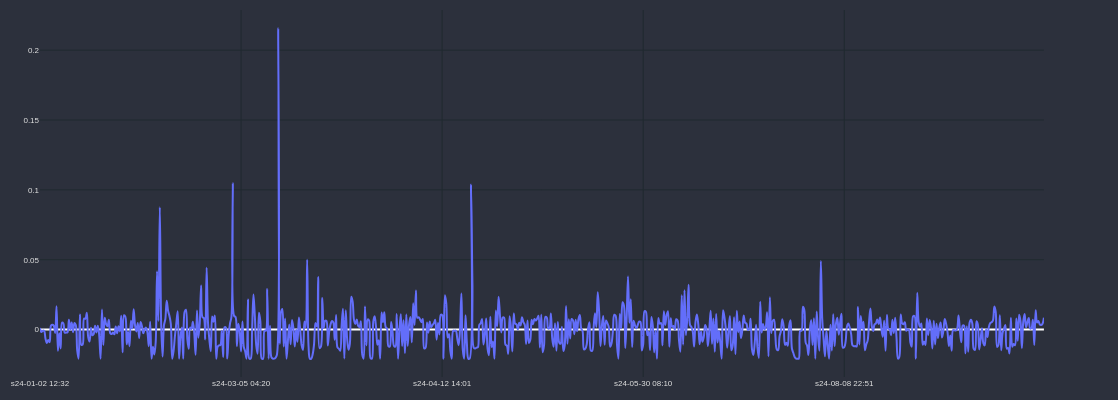

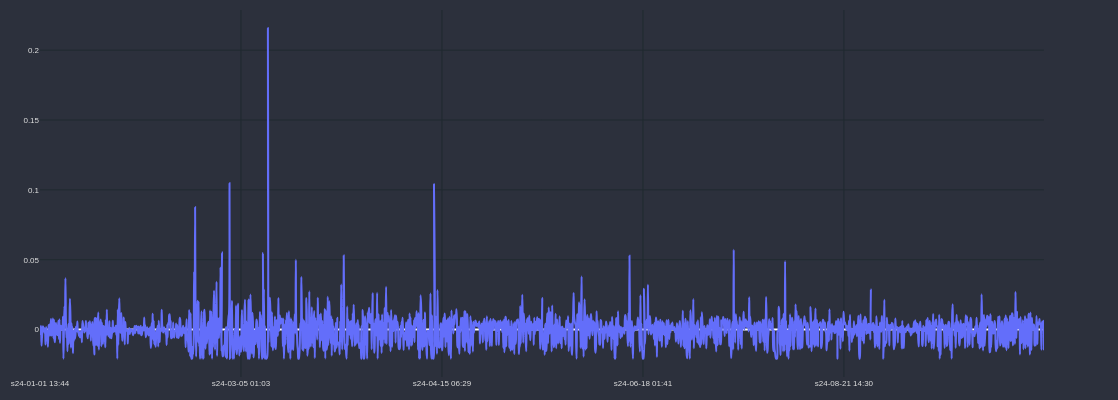

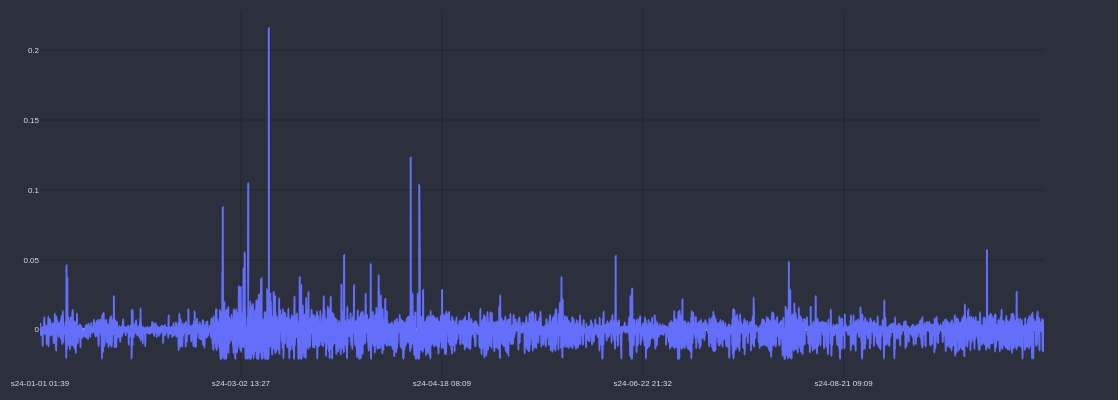

In [36]:
for index in range(len(rank_dict['DOGEUSDT'])):
    rank = rank_dict['DOGEUSDT'].iloc[index]
    rank.r['time'] = rank.r['end_time']
    rank.r['GAIN_I'] = rank.r.strategy_pair1

    cp = CandlePlot(rank.r, candles=False)
    cp.show_plot(line_traces = ['GAIN_I'])

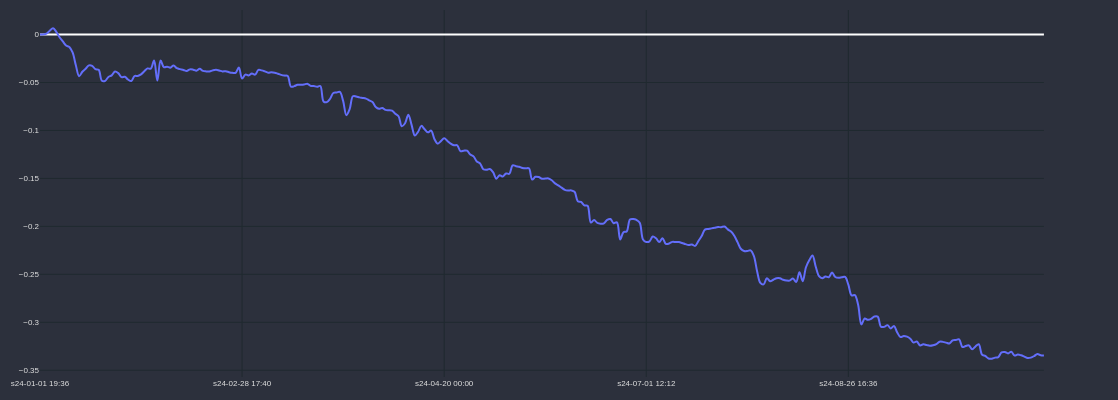

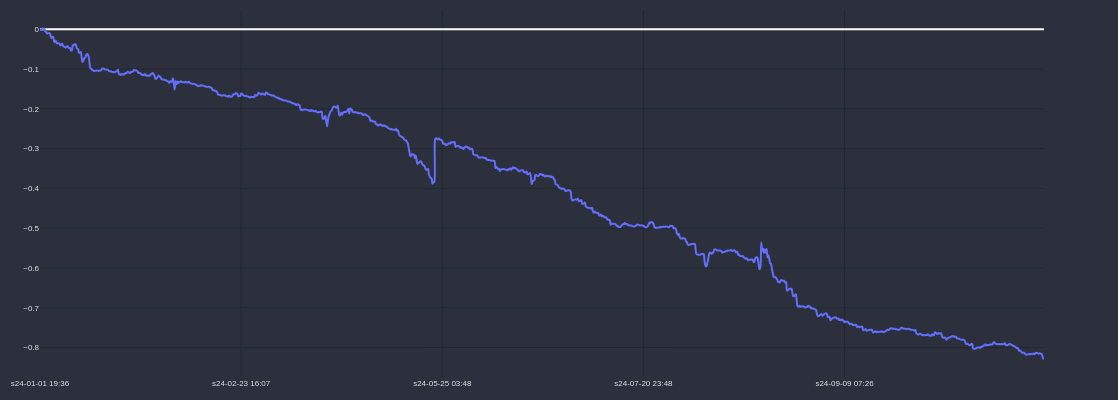

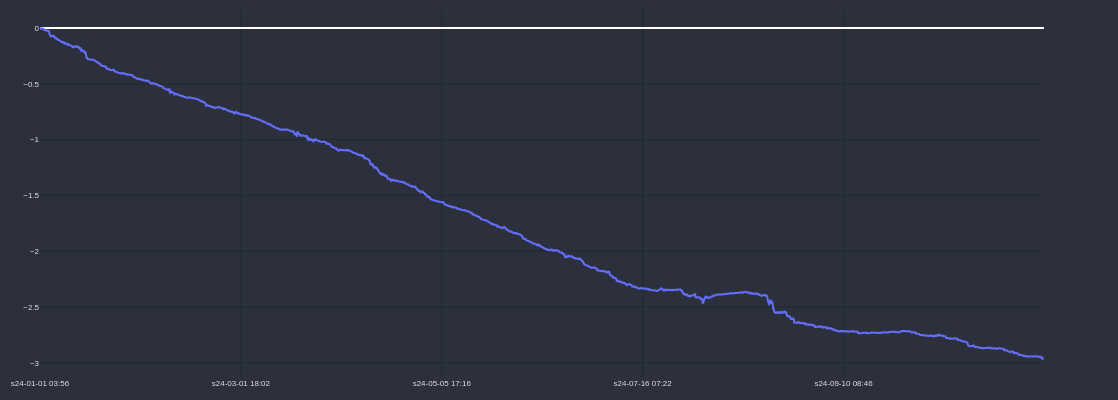

In [33]:
for index in range(len(rank_dict['TRXUSDT'])):
    rank = rank_dict['TRXUSDT'].iloc[index]
    rank.r['time'] = rank.r['end_time']
    rank.r['GAIN_I'] = rank.r.strategy_pair1.cumsum()

    cp = CandlePlot(rank.r, candles=False)
    cp.show_plot(line_traces = ['GAIN_I'])

In [33]:
def calcular_operacoes_simultaneas(df):
    # Ordena o DataFrame por start_time para facilitar o cálculo
    df = df.sort_values(by='start_time').reset_index(drop=True)
    # Inicializa a coluna operacoes_simultaneas com o valor mínimo de 0
    df['operacoes_simultaneas'] = 0
    
    # Itera sobre cada operação e conta quantas estão abertas e não fechadas no momento
    for i, row in df.iterrows():
        # Conta quantas operações estão em andamento no tempo de start_time da operação atual
        count = ((df['start_time'] <= row['start_time']) & (df['end_time'] > row['start_time'])).sum()
        # Atualiza a coluna com o número de operações simultâneas, garantindo o mínimo de 1
        df.at[i, 'operacoes_simultaneas'] = max(count, 1)
        
    return df

In [34]:

# Concatenar os DataFrames filtrados, acessando os 10 primeiros elementos do atributo `r` de cada um
concat_ranks = pd.concat(
    [
        rank_dict['VIDTUSDT'].iloc[index].r for index in range(1)
    ]
)


In [35]:
concat_ranks.shape

(5178, 21)

In [36]:
concat_ranks.strategy_pair1.sum()

np.float64(3.168555484067821)

In [37]:
df_test = calcular_operacoes_simultaneas(concat_ranks)
df_test.operacoes_simultaneas.max()

np.int64(1)

In [38]:
df_test.tail()

running  start_index_m5  count  trigger_type  strategy_pair1  \
5173    False          438614      8             0       -0.001918   
5174    False          438625     41             0       -0.001550   
5175    False          438720     12             0        0.005509   
5176    False          438842      8             0       -0.013037   
5177    False          438850     36             0        0.004560   

      strategy_no_tc  total_opened  first_return  trail_stop_trigger  \
5173       -0.001118             1         False                   0   
5174       -0.000750             1         False                   0   
5175        0.006309             1         False                   0   
5176       -0.012237             1         False                   0   
5177        0.005360             1         False                   0   

      trailing_stop_target  trailing_stop_loss  type  start_price  \
5173                  0.01               -0.01   buy      0.02685   
5174                  0.01               -0.01   buy      0.02669   
5175                  0.01               -0.01  sell      0.02703   
5176                  0.01               -0.01   buy      0.02631   
5177                  0.01               -0.01   buy      0.02605   

      trigger_price  SIGNAL_UP  SIGNAL_DOWN   result            end_time  \
5173        0.02682          1            0 -0.00003 2024-10-31 14:21:00   
5174        0.02667          1            0 -0.00002 2024-10-31 15:05:00   
5175        0.02686          0            1  0.00017 2024-10-31 16:11:00   
5176        0.02599          1            0 -0.00032 2024-10-31 18:09:00   
5177        0.02619          1            0  0.00014 2024-10-31 18:45:00   

              start_time                time    GAIN_I  operacoes_simultaneas  
5173 2024-10-31 14:14:00 2024-10-31 14:21:00  3.173073                      1  
5174 2024-10-31 14:25:00 2024-10-31 15:05:00  3.171524                      1  
5175 2024-10-31 16:00:00 2024-10-31 16:11:00  3.177033                      1  
5176 2024-10-31 18:02:00 2024-10-31 18:09:00  3.163996                      1  
5177 2024-10-31 18:10:00 2024-10-31 18:45:00  3.168555                      1

In [39]:
concat_ranks.columns

Index(['running', 'start_index_m5', 'count', 'trigger_type', 'strategy_pair1',
       'strategy_no_tc', 'total_opened', 'first_return', 'trail_stop_trigger',
       'trailing_stop_target', 'trailing_stop_loss', 'type', 'start_price',
       'trigger_price', 'SIGNAL_UP', 'SIGNAL_DOWN', 'result', 'end_time',
       'start_time', 'time', 'GAIN_I'],
      dtype='object')

In [40]:
df_test.strategy_pair1.sum()

np.float64(3.168555484067821)

In [41]:
(5000/df_test.operacoes_simultaneas.max()) * df_test.strategy_pair1.sum()

np.float64(15842.777420339105)

In [42]:
df_test.tail()

running  start_index_m5  count  trigger_type  strategy_pair1  \
5173    False          438614      8             0       -0.001918   
5174    False          438625     41             0       -0.001550   
5175    False          438720     12             0        0.005509   
5176    False          438842      8             0       -0.013037   
5177    False          438850     36             0        0.004560   

      strategy_no_tc  total_opened  first_return  trail_stop_trigger  \
5173       -0.001118             1         False                   0   
5174       -0.000750             1         False                   0   
5175        0.006309             1         False                   0   
5176       -0.012237             1         False                   0   
5177        0.005360             1         False                   0   

      trailing_stop_target  trailing_stop_loss  type  start_price  \
5173                  0.01               -0.01   buy      0.02685   
5174                  0.01               -0.01   buy      0.02669   
5175                  0.01               -0.01  sell      0.02703   
5176                  0.01               -0.01   buy      0.02631   
5177                  0.01               -0.01   buy      0.02605   

      trigger_price  SIGNAL_UP  SIGNAL_DOWN   result            end_time  \
5173        0.02682          1            0 -0.00003 2024-10-31 14:21:00   
5174        0.02667          1            0 -0.00002 2024-10-31 15:05:00   
5175        0.02686          0            1  0.00017 2024-10-31 16:11:00   
5176        0.02599          1            0 -0.00032 2024-10-31 18:09:00   
5177        0.02619          1            0  0.00014 2024-10-31 18:45:00   

              start_time                time    GAIN_I  operacoes_simultaneas  
5173 2024-10-31 14:14:00 2024-10-31 14:21:00  3.173073                      1  
5174 2024-10-31 14:25:00 2024-10-31 15:05:00  3.171524                      1  
5175 2024-10-31 16:00:00 2024-10-31 16:11:00  3.177033                      1  
5176 2024-10-31 18:02:00 2024-10-31 18:09:00  3.163996                      1  
5177 2024-10-31 18:10:00 2024-10-31 18:45:00  3.168555                      1

In [43]:
df_test.describe()

start_index_m5        count  trigger_type  strategy_pair1  \
count     5178.000000  5178.000000        5178.0     5178.000000   
mean    217449.998841    37.582657           0.0        0.000612   
min         67.000000     2.000000           0.0       -0.116347   
25%     106826.250000     7.000000           0.0       -0.002278   
50%     218764.500000    15.000000           0.0        0.001825   
75%     328235.750000    32.000000           0.0        0.004963   
max     438850.000000  8174.000000           0.0        0.265519   
std     124903.570606   248.583366           0.0        0.011577   

       strategy_no_tc  total_opened  trail_stop_trigger  trailing_stop_target  \
count     5178.000000        5178.0         5178.000000           5178.000000   
mean         0.001412           1.0            0.123986              0.013143   
min         -0.115547           1.0            0.000000              0.010000   
25%         -0.001478           1.0            0.000000              0.010000   
50%          0.002625           1.0            0.000000              0.010000   
75%          0.005763           1.0            0.000000              0.010000   
max          0.266319           1.0            1.000000              0.576650   
std          0.011577           0.0            0.329598              0.018226   

       trailing_stop_loss  start_price  trigger_price    SIGNAL_UP  \
count         5178.000000  5178.000000    5178.000000  5178.000000   
mean            -0.006824     0.033863       0.033866     0.460216   
min             -0.010000     0.013900       0.013900     0.000000   
25%             -0.010000     0.027558       0.027558     0.000000   
50%             -0.010000     0.032940       0.032930     0.000000   
75%             -0.010000     0.040828       0.040917     1.000000   
max              0.264934     0.069160       0.068900     1.000000   
std              0.010616     0.010484       0.010489     0.498463   

       SIGNAL_DOWN       result                       end_time  \
count  5178.000000  5178.000000                           5178   
mean      0.539784     0.000044  2024-05-31 00:46:34.889918976   
min       0.000000    -0.004630            2024-01-01 01:38:00   
25%       0.000000    -0.000040            2024-03-15 04:37:30   
50%       1.000000     0.000070            2024-05-31 22:12:00   
75%       1.000000     0.000180            2024-08-15 23:05:45   
max       1.000000     0.016170            2024-10-31 18:45:00   
std       0.498463     0.000499                            NaN   

                          start_time                           time  \
count                           5178                           5178   
mean   2024-05-31 00:09:59.930475008  2024-05-31 00:46:34.889918976   
min              2024-01-01 01:07:00            2024-01-01 01:38:00   
25%              2024-03-15 04:26:15            2024-03-15 04:37:30   
50%              2024-05-31 22:04:30            2024-05-31 22:12:00   
75%              2024-08-15 22:35:45            2024-08-15 23:05:45   
max              2024-10-31 18:10:00            2024-10-31 18:45:00   
std                              NaN                            NaN   

            GAIN_I  operacoes_simultaneas  
count  5178.000000                 5178.0  
mean      1.815527                    1.0  
min      -0.054550                    1.0  
25%       0.173846                    1.0  
50%       1.878218                    1.0  
75%       3.345353                    1.0  
max       4.177280                    1.0  
std       1.486379                    0.0

In [44]:
df_test = df_test.sort_values(by='end_time', ascending=True).reset_index(drop=True)
df_test.head()

running  start_index_m5  count  trigger_type  strategy_pair1  \
0    False              67     32             0        0.007753   
1    False             133     14             0        0.001339   
2    False             246     54             0        0.006415   
3    False             300     20             0        0.000286   
4    False             405     19             0       -0.010793   

   strategy_no_tc  total_opened  first_return  trail_stop_trigger  \
0        0.008553             1         False                   0   
1        0.002139             1         False                   0   
2        0.007215             1         False                   1   
3        0.001086             1         False                   0   
4       -0.009993             1         False                   0   

   trailing_stop_target  trailing_stop_loss  type  start_price  trigger_price  \
0                 0.010           -0.010000   buy      0.02794        0.02818   
1                 0.010           -0.010000   buy      0.02802        0.02808   
2                 0.015            0.007713  sell      0.02782        0.02762   
3                 0.010           -0.010000  sell      0.02763        0.02760   
4                 0.010           -0.010000  sell      0.02788        0.02816   

   SIGNAL_UP  SIGNAL_DOWN   result            end_time          start_time  \
0          1            0  0.00024 2024-01-01 01:38:00 2024-01-01 01:07:00   
1          1            0  0.00006 2024-01-01 02:26:00 2024-01-01 02:13:00   
2          0            1  0.00020 2024-01-01 04:59:00 2024-01-01 04:06:00   
3          0            1  0.00003 2024-01-01 05:19:00 2024-01-01 05:00:00   
4          0            1 -0.00028 2024-01-01 07:03:00 2024-01-01 06:45:00   

                 time    GAIN_I  operacoes_simultaneas  
0 2024-01-01 01:38:00  0.007753                      1  
1 2024-01-01 02:26:00  0.009092                      1  
2 2024-01-01 04:59:00  0.015507                      1  
3 2024-01-01 05:19:00  0.015794                      1  
4 2024-01-01 07:03:00  0.005001                      1

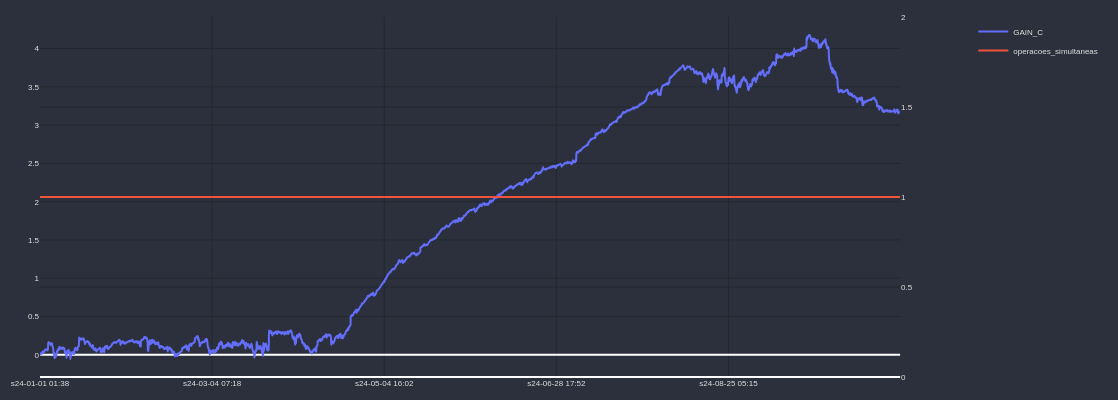

In [45]:

df_test['time'] = df_test['end_time']
df_test['GAIN_C'] = df_test.strategy_pair1.cumsum()

cp = CandlePlot(df_test, candles=False)
cp.show_plot(line_traces = ['GAIN_C'], sec_traces=['operacoes_simultaneas'])

In [46]:
pos = df_test[df_test['strategy_pair1']>0]
neg = df_test[df_test['strategy_pair1']<0]

print(len(pos),len(neg), len(pos)/(len(pos)+len(neg)))

3381 1797 0.652954808806489


In [47]:
df_test.columns

Index(['running', 'start_index_m5', 'count', 'trigger_type', 'strategy_pair1',
       'strategy_no_tc', 'total_opened', 'first_return', 'trail_stop_trigger',
       'trailing_stop_target', 'trailing_stop_loss', 'type', 'start_price',
       'trigger_price', 'SIGNAL_UP', 'SIGNAL_DOWN', 'result', 'end_time',
       'start_time', 'time', 'GAIN_I', 'operacoes_simultaneas', 'GAIN_C'],
      dtype='object')

In [48]:
import numpy as np
import pandas as pd

def calcular_retorno_dinamico_com_alavancagem(df, saldo_total, alavancagem=1, percentual_capital=10):
    """
    Calcula o retorno acumulado em dólar com controle de reserva, considerando operações simultâneas e mantendo
    o saldo total inalterado até que as operações sejam fechadas. Adiciona incremento de 2% ao capital usado.

    Parâmetros:
        df (pd.DataFrame): DataFrame contendo as colunas `start_time`, `end_time`, e `strategy`.
        saldo_total (float): Saldo total inicial disponível para operações.
        alavancagem (float): Fator de alavancagem a ser aplicado nas operações.
        percentual_capital (float): Percentual do saldo total a ser usado em cada operação.

    Retorno:
        pd.DataFrame: DataFrame atualizado com colunas adicionais e métricas.
    """
    # Ordenar o DataFrame pelo tempo de abertura
    df = df.sort_values(by="start_time").reset_index(drop=True)

    # Inicializar arrays e variáveis
    n = len(df)
    capital_usado = saldo_total / percentual_capital
    incremento_percentual = 0.0

    status = np.full(n, "fechada", dtype=object)
    retorno_dolar = np.zeros(n)
    capital_acumulado = np.full(n, saldo_total)
    saldo_total_arr = np.full(n, saldo_total)
    capital_usado_arr = np.zeros(n)

    for i in range(n):
        # Fechar operações cujo end_time já passou
        abertas = (status == "aberta") & (df["end_time"].values <= df["start_time"].iloc[i])
        for j in np.where(abertas)[0]:
            retorno_alavancado = alavancagem * (df["strategy_pair1"].iloc[j] * capital_usado_arr[j])
            saldo_total += retorno_alavancado  # Atualizar saldo total com o retorno da operação
            retorno_dolar[j] = retorno_alavancado
            status[j] = "fechada"
            # Recalcular o capital usado após fechar uma operação
            capital_usado = saldo_total / percentual_capital

        # Incrementar o capital usado em 2% para a nova operação
        capital_usado *= (1 + incremento_percentual)
        capital_usado_arr[i] = capital_usado

        # Marcar a operação como aberta
        status[i] = "aberta"

        # Atualizar o saldo acumulado e saldo total
        saldo_total_arr[i] = saldo_total
        capital_acumulado[i] = saldo_total

    # Adicionar os resultados ao DataFrame
    df["capital_usado"] = capital_usado_arr
    df["retorno_dolar"] = retorno_dolar
    df["capital_acumulado"] = capital_acumulado
    df["saldo_total"] = saldo_total_arr
    df["status"] = status

    print("Resumo Final:")
    print(f"Saldo total final: ${saldo_total:.2f}")
    return df


In [49]:
df_test.operacoes_simultaneas.mean()

np.float64(1.0)

In [50]:
# valor_inicial = 5.0
saldo_total = 200.0

# Exemplo de uso com alavancagem
df_resultado_dinamico_alavancagem = calcular_retorno_dinamico_com_alavancagem(
    df_test, saldo_total, alavancagem=5, percentual_capital=1
)

Resumo Final:
Saldo total final: $376425.89


In [51]:
df_test.strategy_pair1.sum()

np.float64(3.168555484067821)

In [52]:
df_resultado_dinamico_alavancagem[["start_time", "end_time", "strategy_pair1", "capital_usado", "retorno_dolar",
              "capital_acumulado", "saldo_total"]].head(2500)

start_time            end_time  strategy_pair1  capital_usado  \
0    2024-01-01 01:07:00 2024-01-01 01:38:00        0.007753     200.000000   
1    2024-01-01 02:13:00 2024-01-01 02:26:00        0.001339     207.753153   
2    2024-01-01 04:06:00 2024-01-01 04:59:00        0.006415     209.144100   
3    2024-01-01 05:00:00 2024-01-01 05:19:00        0.000286     215.852437   
4    2024-01-01 06:45:00 2024-01-01 07:03:00       -0.010793     216.161501   
5    2024-01-01 07:04:00 2024-01-01 07:08:00        0.007759     204.496405   
6    2024-01-01 07:22:00 2024-01-01 07:56:00       -0.001159     212.430102   
7    2024-01-01 09:06:00 2024-01-01 09:17:00        0.005266     211.199478   
8    2024-01-01 09:50:00 2024-01-01 10:09:00        0.007369     216.760393   
9    2024-01-01 13:04:00 2024-01-01 13:40:00        0.003449     224.747048   
10   2024-01-01 15:46:00 2024-01-01 15:48:00        0.000602     228.623146   
11   2024-01-01 15:52:00 2024-01-01 16:09:00       -0.012237     229.310778   
12   2024-01-01 16:10:00 2024-01-01 16:30:00        0.010593     215.280837   
13   2024-01-01 16:31:00 2024-01-01 16:37:00        0.005108     226.683384   
14   2024-01-01 16:50:00 2024-01-01 17:01:00       -0.000800     232.472791   
15   2024-01-01 19:05:00 2024-01-01 19:09:00        0.004596     231.542900   
16   2024-01-01 19:21:00 2024-01-01 19:39:00        0.007966     236.864106   
17   2024-01-01 19:43:00 2024-01-01 19:51:00       -0.022435     246.298488   
18   2024-01-01 19:52:00 2024-01-01 19:53:00        0.012551     218.669882   
19   2024-01-02 00:03:00 2024-01-02 00:47:00       -0.007229     232.392875   
20   2024-01-02 00:59:00 2024-01-02 01:07:00        0.001875     223.993366   
21   2024-01-02 06:12:00 2024-01-02 06:49:00        0.002888     226.092959   
22   2024-01-02 06:57:00 2024-01-02 07:12:00        0.005945     229.357951   
23   2024-01-02 07:51:00 2024-01-02 08:21:00        0.004229     236.176061   
24   2024-01-02 10:01:00 2024-01-02 10:15:00        0.001545     241.170416   
25   2024-01-02 11:34:00 2024-01-02 11:53:00       -0.004857     243.033056   
26   2024-01-02 12:20:00 2024-01-02 12:32:00        0.003600     237.131240   
27   2024-01-02 13:54:00 2024-01-02 14:23:00        0.002565     241.399691   
28   2024-01-02 14:31:00 2024-01-02 15:38:00        0.017841     244.495329   
29   2024-01-02 16:24:00 2024-01-02 16:30:00        0.000913     266.306083   
30   2024-01-02 16:41:00 2024-01-02 16:46:00        0.002618     267.522049   
31   2024-01-02 17:15:00 2024-01-02 18:46:00       -0.004905     271.023428   
32   2024-01-02 20:28:00 2024-01-02 21:04:00        0.007784     264.376068   
33   2024-01-02 23:27:00 2024-01-02 23:33:00       -0.001486     274.665246   
34   2024-01-02 23:42:00 2024-01-02 23:46:00       -0.000800     272.624014   
35   2024-01-02 23:55:00 2024-01-03 00:00:00        0.002635     271.533517   
36   2024-01-03 00:15:00 2024-01-03 00:26:00       -0.000800     275.111310   
37   2024-01-03 00:44:00 2024-01-03 01:57:00        0.000571     274.010864   
38   2024-01-03 02:15:00 2024-01-03 02:39:00       -0.002514     274.792894   
39   2024-01-03 02:53:00 2024-01-03 03:42:00       -0.000800     271.338220   
40   2024-01-03 04:08:00 2024-01-03 04:51:00       -0.000458     270.252867   
41   2024-01-03 04:59:00 2024-01-03 05:14:00        0.001590     269.633432   
42   2024-01-03 05:59:00 2024-01-03 06:16:00        0.004966     271.777427   
43   2024-01-03 06:33:00 2024-01-03 07:27:00        0.002573     278.525197   
44   2024-01-03 09:31:00 2024-01-03 09:42:00       -0.002136     282.107985   
45   2024-01-03 10:45:00 2024-01-03 11:15:00       -0.014027     279.095064   
46   2024-01-03 11:16:00 2024-01-03 11:18:00        0.001898     259.520372   
47   2024-01-03 11:55:00 2024-01-03 11:58:00        0.007693     261.983411   
48   2024-01-03 12:01:00 2024-01-03 12:04:00        0.014180     272.061050   
49   2024-01-03 12:08:00 2024-01-03 12:25:00        0.056189    

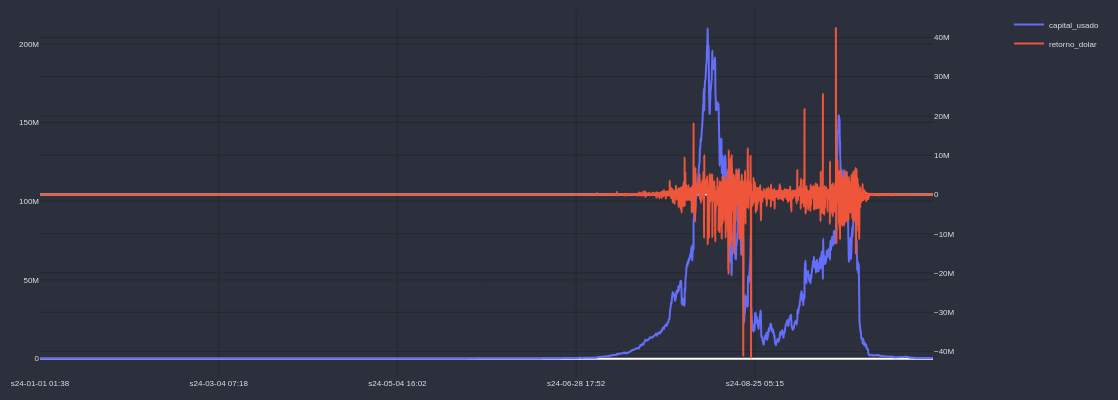

In [53]:
cp = CandlePlot(df_resultado_dinamico_alavancagem, candles=False)
cp.show_plot(line_traces = ['capital_usado'], sec_traces=['retorno_dolar'])

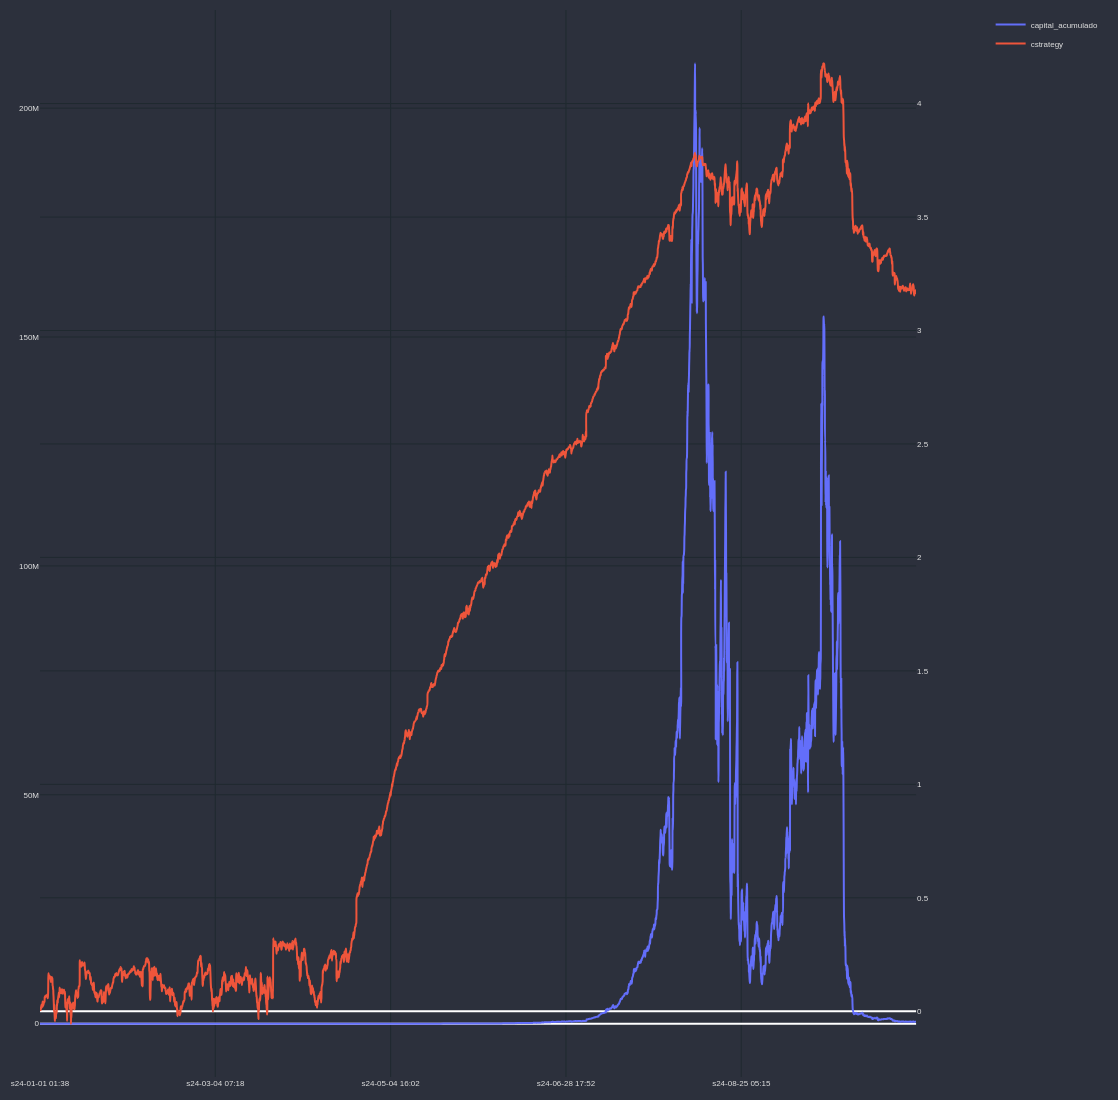

In [54]:
df_resultado_dinamico_alavancagem['cstrategy'] = df_resultado_dinamico_alavancagem.strategy_pair1.cumsum()
cp = CandlePlot(df_resultado_dinamico_alavancagem, candles=False)
cp.show_plot(line_traces = ['capital_acumulado'], sec_traces=['cstrategy'], height=1100)